In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using CSV
using DataFrames
using StatsBase
using Formatting

# config plot settings
PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

## Load Descriptor Data

In [2]:
###
#  read in lines to get COF filenames
###
filename = joinpath(pwd(), "./descriptors/cof_names.txt")
cof_name_file = open(filename)
cof_names = readlines(cof_name_file)
close(cof_name_file)

###
#  load properties
###
chem_props_filename = joinpath(pwd(), "descriptors/chemical_properties.csv")
geo_props_filename  = joinpath(pwd(), "descriptors/geometric_properties.csv")

chemical_properties  = CSV.read(chem_props_filename, DataFrame)
geometric_properties = CSV.read(geo_props_filename, DataFrame)

descriptors = outerjoin(geometric_properties, chemical_properties, on=["crystal_name"]);

In [3]:
# for some reason these ones aren't working... LOOk INTO IT
# NOTE: second row has "⟨N⟩ (mmol/g)" = [0.0, 0.0] producing sel = NaN... need to run gcmc on these?
skip_for_now = ["07012N3_ddec.cif", "14040N2_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif",
                "13030N2_ddec.cif", "16371N2_ddec.cif", "20565N3_ddec.cif", "21090N3_ddec.cif"] 

filter!(row -> ! (row["crystal_name"] in skip_for_now), descriptors);

In [4]:
###
#  simulation parameters
###
adsorbates = Molecule.(["Kr", "Xe"])
mole_fxn   = [0.8, 0.2] # [Kr, Xe]
total_pressure = 1.0    # bar
partial_pressures = total_pressure * mole_fxn

temperature = 298.0 # K
ljff = LJForceField("UFF")
nb_ins_per_vol = 500
nb_cyc_per_vol = 500 # 150

benchmarked_cofs = ["05000N2_ddec.cif", "17156N2_ddec.cif"]

2-element Vector{String}:
 "05000N2_ddec.cif"
 "17156N2_ddec.cif"

### Calculate Error in Selectivity from Henry Coefficient:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$


In [5]:
function calculate_selectivity(n1::Float64, n2::Float64, 
                               dn1::Float64, dn2::Float64;
                               fxn1::Float64=1.0, fxn2::Float64=1.0)
    
    selectivity = (n1 / fxn1) / (n2 / fxn2)
    err_selectivity = selectivity * sqrt((dn1 / n1) ^ 2 + (dn2 / n2) ^ 2) # mole fraction in error?
    return selectivity, err_selectivity
end

calculate_selectivity (generic function with 1 method)

In [6]:
function calculate_num_burn_and_sample_cycles(xtal::Crystal, cycles_per_volume::Int64; 
                                              fraction_burn_cycles::Float64=0.5)
    nb_cycles = max(5, ceil(Int, cycles_per_volume * xtal.box.Ω))
    @assert (0.0 < fraction_burn_cycles) && (fraction_burn_cycles < 1.0) 
    n_burn_cycles   = ceil(Int, nb_cycles * fraction_burn_cycles)
    n_sample_cycles = ceil(Int, nb_cycles * (1 - fraction_burn_cycles))
    return n_burn_cycles, n_sample_cycles
end

calculate_num_burn_and_sample_cycles (generic function with 1 method)

## Load Simulation Data

In [7]:
###
#  create DataFrame to populate with data we need 
###
df = DataFrame(xtal = descriptors[:, "crystal_name"],
               henry_coeff = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])], 
               err_henry_coeff = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])],
               henry_elapsed_time = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])],
               henry_total_elapsed_time = zeros(Float64, length(descriptors[:, "crystal_name"])),
               henry_selectivity = zeros(Float64, length(descriptors[:, "crystal_name"])),
               err_henry_selectivity = zeros(Float64, length(descriptors[:, "crystal_name"])),
               gcmc_uptake = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])],
               err_gcmc_uptake = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])],
               gcmc_pressure = [zeros(Float64, length(adsorbates)) for i in 1:length(descriptors[:, "crystal_name"])],
               gcmc_elapsed_time = zeros(Float64, length(descriptors[:, "crystal_name"])),
               gcmc_selectivity = zeros(Float64, length(descriptors[:, "crystal_name"])),
               err_gcmc_selectivity = zeros(Float64, length(descriptors[:, "crystal_name"]))
               )

###
#  loop over xtals 
###
for (i, row) in enumerate(eachrow(df)) 
    # make sure we are on the correct row
    @assert row[:xtal] == descriptors[i, "crystal_name"]
    
    # load crystal
    xtal = Crystal(row[:xtal]; check_neutrality=false)

    for (j, molecule) in enumerate(adsorbates) # [Kr, Xe]
        ###
        # load and assign Henry data
        ###
        henry_filename = henry_result_savename(xtal, molecule, temperature, ljff, nb_ins_per_vol)
        @load joinpath(PorousMaterials.rc[:paths][:simulations], henry_filename) results
        
        row[:henry_coeff][j] = results["henry coefficient [mmol/(g-bar)]"]
        row[:err_henry_coeff][j] = results["err henry coefficient [mmol/(g-bar)]"]
        row[:henry_elapsed_time][j] = results["elapsed time (min)"]
    end
    # calculate total time to run set of Henry calculations
    row[:henry_total_elapsed_time] = sum(row[:henry_elapsed_time])
    
    ###
    #  load and assign GCMC data
    ###
    n_burn, n_sample = calculate_num_burn_and_sample_cycles(xtal, nb_cyc_per_vol)
    gcmc_filename = μVT_output_filename(xtal, adsorbates, temperature, 
                                        partial_pressures, ljff, n_burn, n_sample)
    @load joinpath(PorousMaterials.rc[:paths][:simulations], gcmc_filename) results

    row[:gcmc_uptake] = results["⟨N⟩ (mmol/g)"]
    row[:err_gcmc_uptake] = results["err ⟨N⟩ (mmol/g)"]
    row[:gcmc_pressure] = results["pressure (bar)"]
    row[:gcmc_elapsed_time] = results["elapsed time (min)"]
    # assert that adsorbates in correct order
    
    ###
    # calculate and assign selectivities with associated error
    ###
    selectivity, err_selectivity = calculate_selectivity(row[:henry_coeff][2],
                                                         row[:henry_coeff][1],
                                                         row[:err_henry_coeff][2],
                                                         row[:err_henry_coeff][1])
    row[:henry_selectivity] = selectivity
    row[:err_henry_selectivity] = err_selectivity
    
    # recall: adsorbates = ["Kr", "Xe"] and we want S_xe/kr
    selectivity, err_selectivity = calculate_selectivity(row[:gcmc_uptake][2],
                                                         row[:gcmc_uptake][1],
                                                         row[:err_gcmc_uptake][2],
                                                         row[:err_gcmc_uptake][1];
                                                         fxn1=0.2, fxn2=0.8) #[Xe, Kr]
    row[:gcmc_selectivity] = selectivity 
    row[:err_gcmc_selectivity] = err_selectivity
end
# write to file (only include xtal name and targets for GP)
CSV.write(joinpath(pwd(), "target_and_cost_data.csv"), df[:, [:xtal, :henry_selectivity, :gcmc_selectivity]])

"/home/ng/multi-fidelity-BO-of-COFs-for-Xe-Kr-seps/target_and_cost_data.csv"

In [8]:
df[1:5, [:xtal, :henry_selectivity, :gcmc_selectivity]]

,xtal,henry_selectivity,gcmc_selectivity
,String?,Float64,Float64
1,05000N2_ddec.cif,1.58051,1.69624
2,05001N2_ddec.cif,3.27135,3.2725
3,07000N2_ddec.cif,2.9979,2.99372
4,07001N2_ddec.cif,9.01379,9.65039
5,07002N2_ddec.cif,3.60253,3.64401


In [9]:
###
#  Compute statistics about the fit
#  RMSE, R2 and Spearmann correlation
##
rmse = sqrt(mean((df[:, :gcmc_selectivity] - df[:, :henry_selectivity]).^2))

R2 = 1.0 - (sum((df[:, :gcmc_selectivity] - df[:, :henry_selectivity]).^2) / 
            sum((df[:, :gcmc_selectivity] .- mean(df[:, :gcmc_selectivity])).^2))

rho_spearman = corspearman(df[:, :gcmc_selectivity], df[:, :henry_selectivity])

0.9984326629127909

## Plotting:

1. Pore size dist
2. Cost H vs. Cost GCMC 
3. GCMC S vs H S
4. Relative errors

In [11]:
# useful for plot formating 
mkr_sz = [8 for i in 1:length(descriptors[:, "crystal_name"])];
mkr_c = ["C1" for i in 1:length(descriptors[:, "crystal_name"])]

# color benchmark cofs red
mkr_c[findfirst(descriptors[:, "crystal_name"] .== benchmarked_cofs[1])] = "C0"
mkr_c[findfirst(descriptors[:, "crystal_name"] .== benchmarked_cofs[2])] = "C0"

"C0"

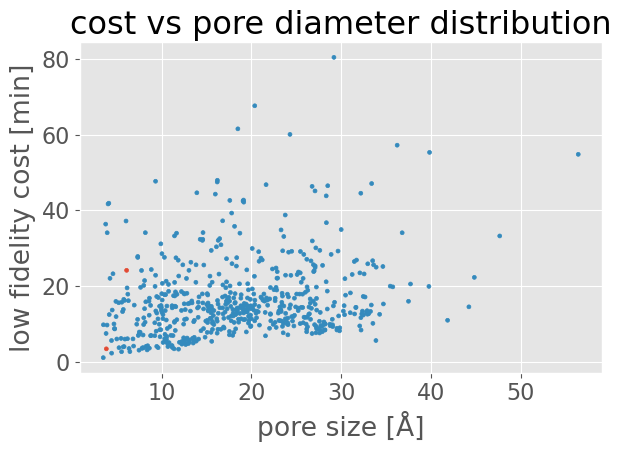

In [12]:
fig = figure()

scatter(descriptors[:, "pore_diameter_Å"], df[:, :henry_total_elapsed_time], color=mkr_c, s=mkr_sz)

title("cost vs pore diameter distribution")
xlabel("pore size [Å]")
ylabel("low fidelity cost [min]")

tight_layout()

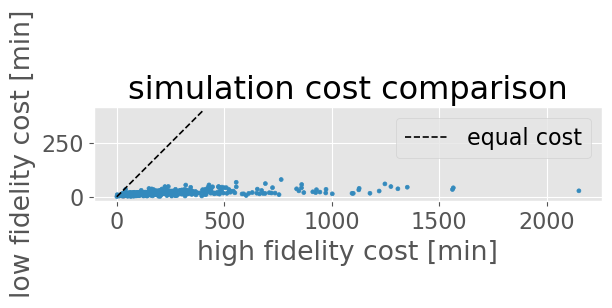

cost ratio: 0.0033112582781456954 unfavorable, 0.9966887417218543 favorable


In [13]:
figure()

scatter(df[:, :gcmc_elapsed_time], df[:, :henry_total_elapsed_time], color=mkr_c, s=mkr_sz)

# track fraction above or on the equal cost line
unfavorable = sum(sum.(df[:, :henry_elapsed_time]) .>= df[:, :gcmc_elapsed_time])
favorable = length(df[:, :gcmc_elapsed_time]) - unfavorable

cost_ratio = unfavorable / length(df[:, :gcmc_elapsed_time])
println("cost ratio: $(cost_ratio) unfavorable, $(1 - cost_ratio) favorable")

# plot the line: y=x
x = range(0.0, stop=400, length=100)
y = x
plot(x, y; label="equal cost", color="k", linestyle="--", linewidth=1.2)

# xlim(xmax=500.0)
# ylim([0.0, 500.0])
# note: make axis equal
gca().set_aspect("equal", adjustable="box")

title("simulation cost comparison")
legend()
xlabel("high fidelity cost [min]")
ylabel("low fidelity cost [min]")

tight_layout()

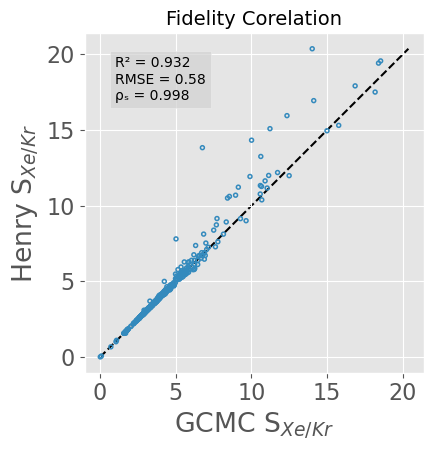

In [25]:
figure()

xmax = maximum(max.(df[:, :gcmc_selectivity], df[:, :henry_selectivity]))
x = range(0.0, stop=xmax, length=length(df[:, :henry_selectivity]))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(df[:, :gcmc_selectivity], df[:, :henry_selectivity], 
        facecolor="none", edgecolor="C1", s=8, linewidth=1.1)

# put a line and calc Spearmann Correlation
str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", R2, rmse, rho_spearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.75)
text(1, 17, str, color="k", size=10, bbox=box_styl)

gca().set_aspect("equal", adjustable="box")

title("Fidelity Corelation", fontsize=14)
xlabel("GCMC S" * L"_{Xe/Kr}")
ylabel("Henry S" * L"_{Xe/Kr}")
tight_layout()
savefig(joinpath(pwd(), "low_vs_high_fidelity_correlation_plot.png"), dpi=600, format="png")

### Look at relative errors in adsorption or each COF

**Note that the Kinetic diameter of Kr = 3.6 Å and Xe = 3.96 Å; 
therefore, COFs with a smaller pore diameter will not be able to accomidate the gas**

In [16]:
cof_large_error = String[]
for (i, row) in enumerate(eachrow(df))
    if any((row[:err_henry_coeff] ./ row[:henry_coeff]) .> 0.05)
        if ! (row[:xtal] in cof_large_error)
            push!(cof_large_error, row[:xtal])
        end
    elseif any((row[:err_gcmc_uptake] ./ row[:gcmc_uptake]) .> 0.05)
        if ! (row[:xtal] in cof_large_error)
            push!(cof_large_error, row[:xtal])
        end
    end
end
cof_large_error # look at their xtal structure... 8 and 30Å should be big enough...?

10-element Vector{String}:
 "05000N2_ddec.cif"
 "15000N2_ddec.cif"
 "15111N2_ddec.cif"
 "17120N2_ddec.cif"
 "18010N3_ddec.cif"
 "18120N3_ddec.cif"
 "19251N3_ddec.cif"
 "19253N3_ddec.cif"
 "20570N3_ddec.cif"
 "21150N2_ddec.cif"

In [17]:
xtal_indexes = [findfirst(descriptors[:, "crystal_name"] .== name) for name in cof_large_error]
pore_diameters = descriptors[xtal_indexes, "pore_diameter_Å"]

10-element Vector{Union{Missing, Float64}}:
  3.84928
  3.5094
 30.32973
  4.42631
  3.82355
  3.93108
  3.77734
  3.94484
  3.52587
  8.85682

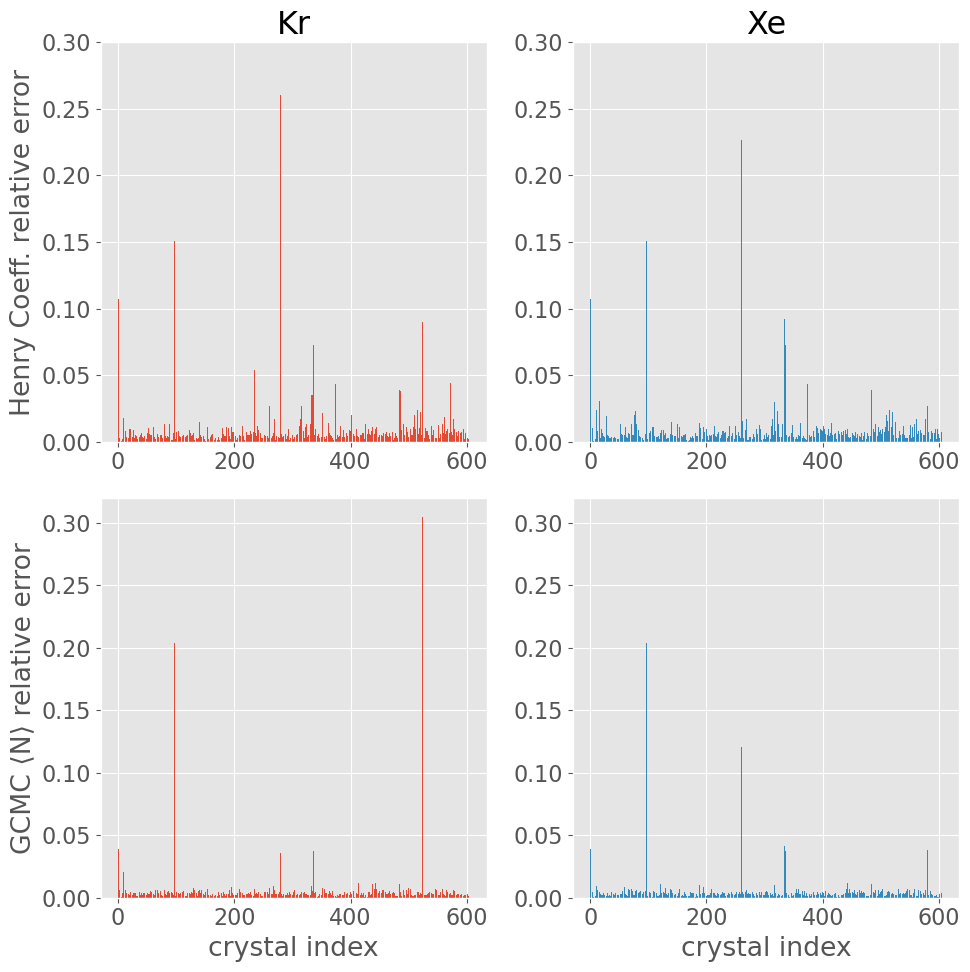

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

x = [ind for ind in 1:length(df[:, :xtal])];
for i in 1:2
    h_rel_err = [df[ind, :err_henry_coeff][2] for ind in 1:length(df[:, :xtal])] ./ 
                [df[ind, :henry_coeff][2] for ind in 1:length(df[:, :xtal])]
    g_rel_err = [df[ind, :err_gcmc_uptake][1] for ind in 1:length(df[:, :xtal])] ./ 
                [df[ind, :gcmc_uptake][1] for ind in 1:length(df[:, :xtal])] 
    axs[1, i].bar(x, h_rel_err, color="C$(i-1)")
    axs[2, i].bar(x, g_rel_err, color="C$(i-1)")
end

axs[1, 1].set_title("Kr")
axs[1, 2].set_title("Xe")
axs[1, 1].set_ylabel("Henry Coeff. relative error")
axs[2, 1].set_ylabel("GCMC ⟨N⟩ relative error")
axs[2, 1].set_xlabel("crystal index")
axs[2, 2].set_xlabel("crystal index")

axs[1, 1].set_ylim([0.00, 0.30])
axs[1, 2].set_ylim([0.00, 0.30])


tight_layout()
savefig(joinpath(pwd(), "relative_eror_plot.png"), dpi=600, format="png")